# Scan aerosols and look at color dependence
=========================================================================


The purpose is to start to use PySynPhot software to calculate things on
SED, filter transmission,... For Calibration

- Sylvie Dagoret-Campagne
- Affiliation LAL-IN2P3-CNRS
- Work : LSST & StarDice
- date November 22 2017




- Read filters for LSST provided by KG May 30th 2017
- Generate LibRadTran atmosphere for any airmass - H2O - O3 combinations
- Generate the observed spectrum

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd
import os
import re 

In [4]:
import pysynphot as S

In [5]:
import astropy.units as u

In [6]:
from scipy.interpolate import interp1d

In [7]:
os.environ['PYSYN_CDBS']

'/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs'

In [8]:
import sys
sys.path.append('../libradtransim')
sys.path.append('../LSSTFiltersKG')
sys.path.append('../lsstphotometry')

In [9]:
import libsimulateTranspLSSTScattAbsAer as atm
import libLSSTFiltersKG as lsst
import libLSSTPhotometry as photo

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 350000.0


In [10]:
#help(atm)

# Defining LSST telescope

In [11]:
LSST_COLL_SURF=35*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [12]:
NBINS=100000
BinWidth=(WLMAX-WLMIN)/float(NBINS)
WL=np.linspace(WLMIN,WLMAX,NBINS)

In [13]:
LSST_COLL_SURF.decompose()

<Quantity 350000.0>

In [14]:
S.refs.setref(area=LSST_COLL_SURF.decompose(), waveset=None)

In [15]:
S.refs.set_default_waveset(minwave=3000, maxwave=11000, num=8000, delta=1, log=False)

In [16]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 350000.0


## LSST effective filter


### Get the bands à la pysynphot

In [17]:
bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4=lsst.GetAllLSSTBands('..')

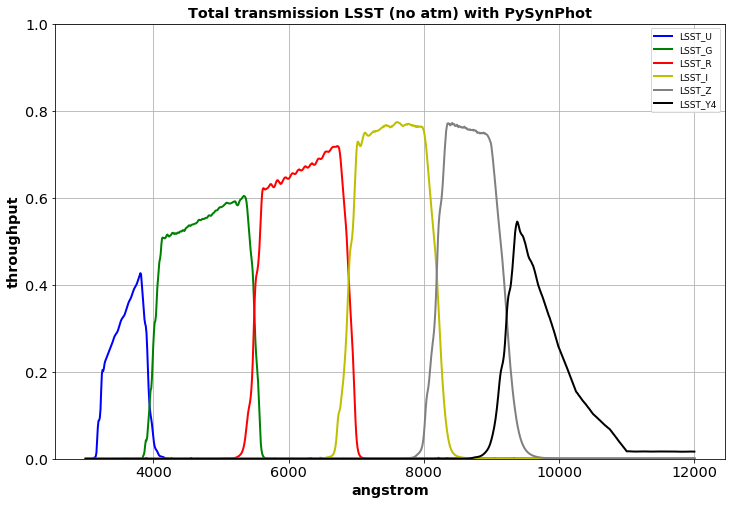

In [18]:
lsst.PlotAllLSSTBands(bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4)

## Fills all bands of LSST

### Create a LSSTTransmission object

In [19]:
lsstdetector=photo.LSSTTransmission('lssttel')

### Initialize the LSST transmission object with the bands read above

In [20]:
lsstdetector.fill_det_allbands([bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4])

## Read atmosphere

In [21]:
tau_aerosol=np.linspace(0.,0.1,10)
lambda0_aerosol=500. # nm
airmass=1.
pwv=4.0     # mm
ozone=300. # DU

In [22]:
photo_atm=photo.Atmosphere('libradtran')

In [23]:
index=0
for tau in tau_aerosol:
      path,thefile=atm.ProcessSimulationaer(airmass,pwv,ozone,lambda0_aerosol,tau) 
      fullfilename=os.path.join(path,thefile)
      atm_data=np.loadtxt(fullfilename)
      wl_atm=atm_data[:,0]
      tr_atm=atm_data[:,1]  
      if index==0:
        photo_atm.fill_array(wl_atm)        
      photo_atm.fill_array(tr_atm)        
      index+=1

--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT')
--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0111111111111
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer1.INP')
('Output to file         

### Check the output of simulation

In [24]:
theatmosph=photo_atm.get_array()

In [25]:
pd.DataFrame(theatmosph)

,0,1,2,3,4,5,6,7,8,9,...,941,942,943,944,945,946,947,948,949,950
0,250.0,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,...,1191.000000,1192.000000,1193.000000,1194.000000,1195.000000,1196.000000,1197.000000,1198.000000,1199.000000,1200.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.963772,0.985182,0.985182,0.970041,0.970041,0.977899,0.977899,0.963689,0.963689,0.960683
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.960666,0.982012,0.982012,0.966929,0.966929,0.974768,0.974768,0.960614,0.960614,0.957626
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.957569,0.978851,0.978851,0.963827,0.963827,0.971647,0.971647,0.957549,0.957549,0.954578
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.954483,0.975701,0.975701,0.960735,0.960735,0.968535,0.968535,0.954494,0.954494,0.951540
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.951407,0.972561,0.972561,0.957653,0.957653,0.965434,0.965434,0.951449,0.951449,0.948511
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.948341,0.969432,0.969432,0.954581,0.954581,0.962343,0.962343,0.948413,0.948413,0.945492
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.945284,0.966312,0.966312,0.951518,0.951518,0.959262,0.959262,0.945387,0.945387,0.942483
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.942238,0.963202,0.963202,0.948466,0.948466,0.956190,0.956190,0.942370,0.942370,0.939483
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.939201,0.960102,0.960102,0.945423,0.945423,0.953129,0.953129,0.939364,0.939364,0.936493


## Do multiplication

### Get all pysynphot passband for the atmosphere

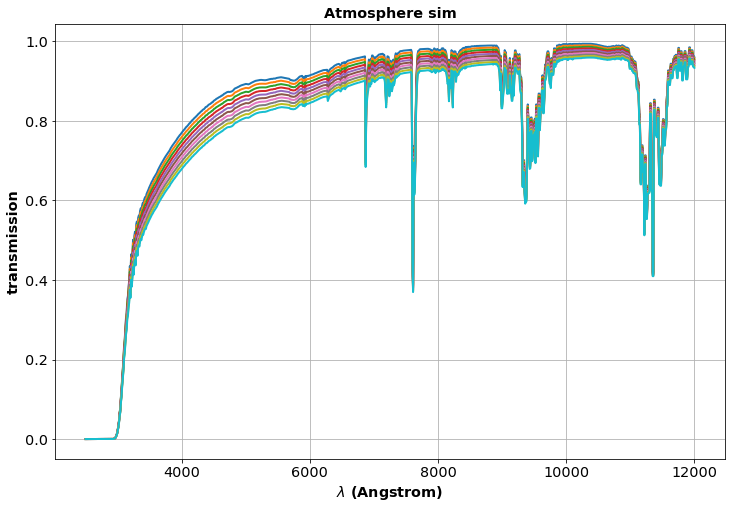

In [26]:
photo_atm.plot_pys_bp()

### Initialise the lsstdetector with the atmosphere results

In [27]:
all_bp_atm=photo_atm.get_pys_pb()

In [28]:
lsstdetector.fill_atm_allevents(all_bp_atm)

### Multiplication of atmosphere transmission by filters transmission

In [29]:
all_transmissions=lsstdetector.make_transmissions()

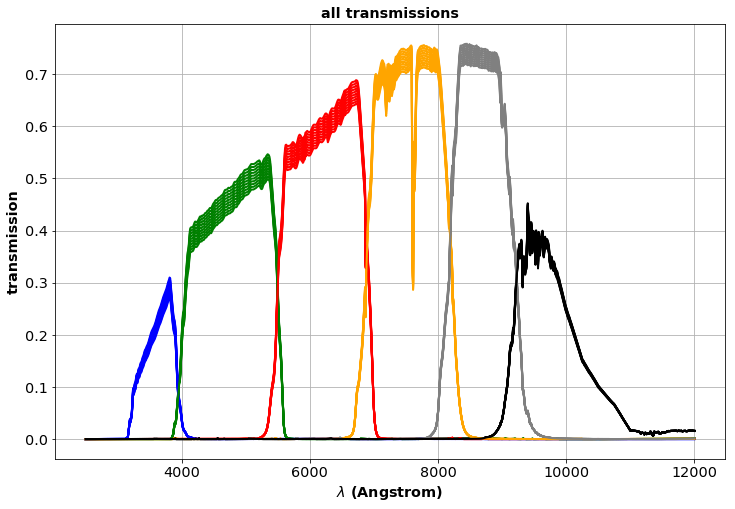

In [30]:
lsstdetector.plot_transmissions()

# Observation

## Defines the SED

In [31]:
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'hd111980_stis_003.fits')
sed = S.FileSpectrum(filename)

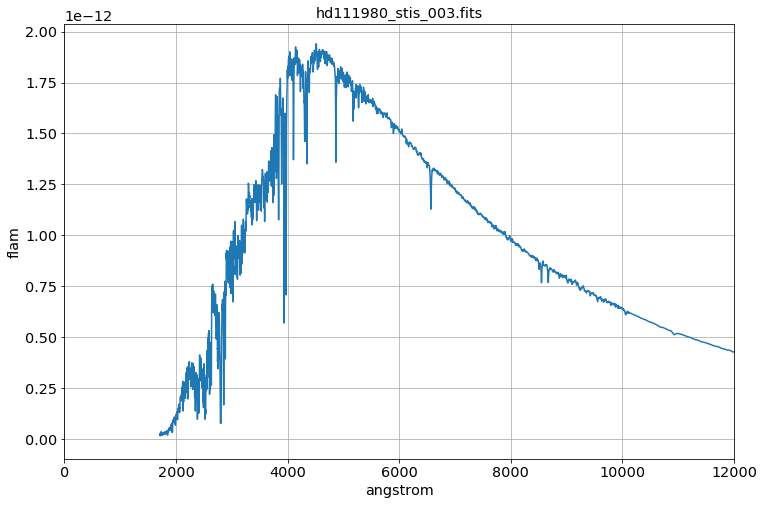

In [32]:
plt.plot(sed.wave,sed.flux)
plt.xlim(0.,12000)
plt.xlabel(sed.waveunits)
plt.ylabel(sed.fluxunits)
plt.title(os.path.basename(sed.name))
plt.grid()

- flam unit is erg per sec per cm2 per angstrom

## Defines all the  observation

In [33]:
rt_observations=photo.LSSTObservation('libradtran_aerosols')

In [34]:
rt_observations.fill_sed([sed])
rt_observations.fill_transmission(all_transmissions)

In [35]:
all_obs=rt_observations.make_observations()

((ATM_1 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_R)) does

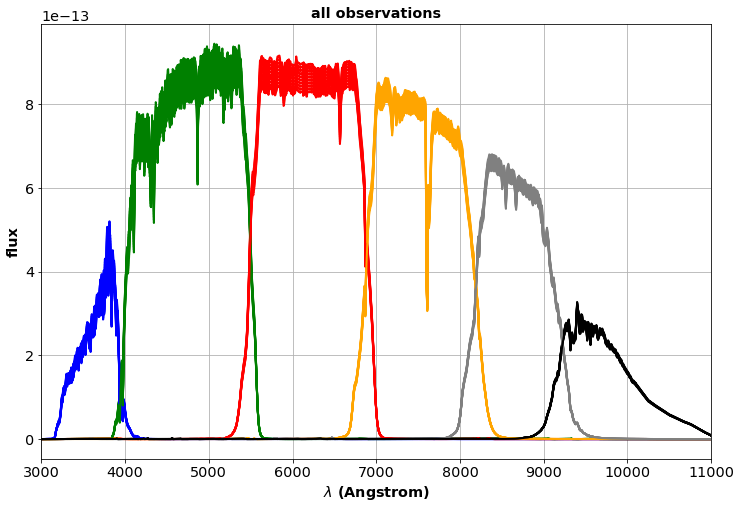

In [36]:
rt_observations.plot_observations(0)

### Magnitude

In [37]:
obssamplarray=rt_observations.make_samplobservations()

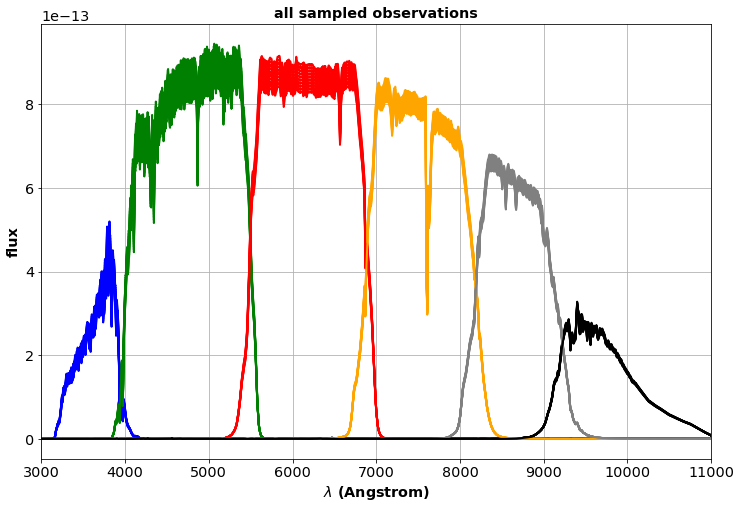

In [38]:
rt_observations.plot_samplobservations(0)

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


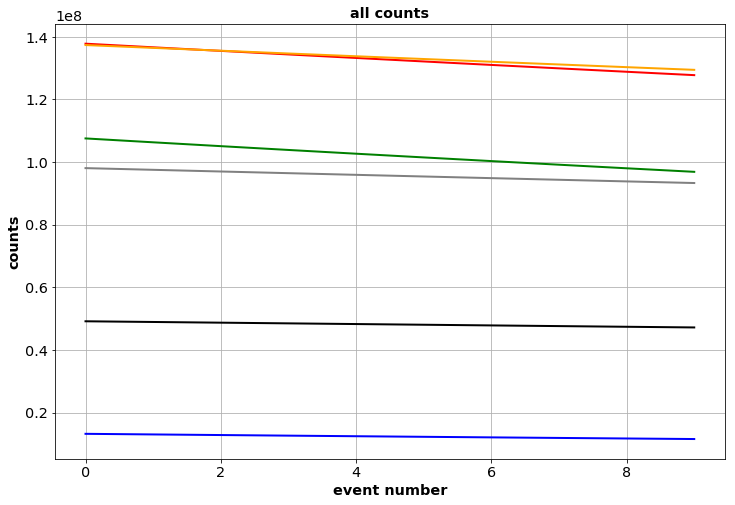

In [40]:
rt_observations.plot_counts(0)

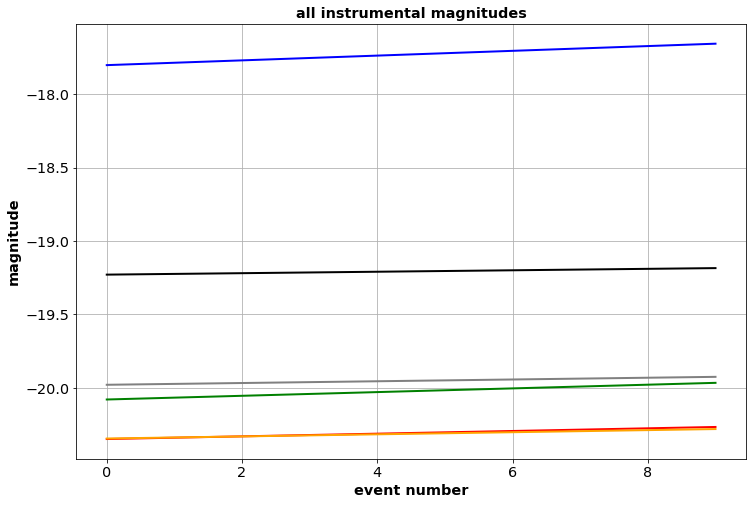

In [41]:
rt_observations.plot_magnitudes(0)

In [42]:
all_magnitudes=np.array(rt_observations.compute_magnitude())[0,:,0]

In [43]:
all_magnitudes

array([-17.80273077, -17.78650572, -17.77028117, -17.75405717,
       -17.73783367, -17.72161072, -17.70538825, -17.68916635,
       -17.67294497, -17.65672412])

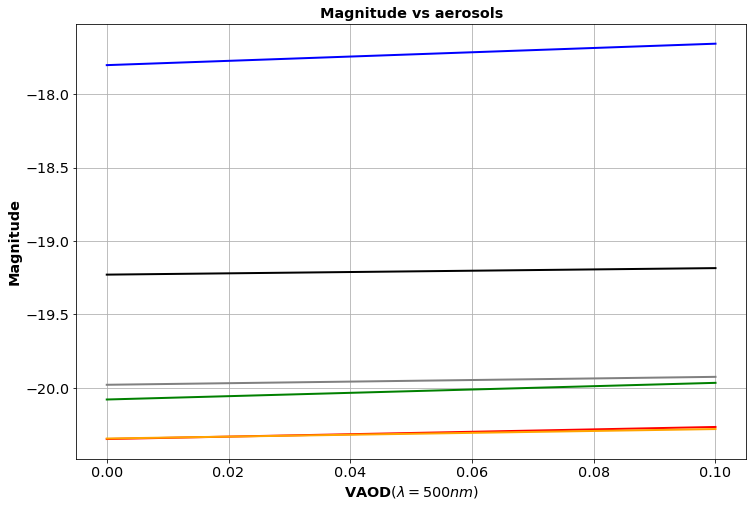

In [44]:
for ifilt in np.arange(photo.NBBANDS):
    mag=rt_observations.get_magnitudeforfilternum(0,ifilt)
    plt.plot(tau_aerosol,mag,color=photo.filtercolor[ifilt],lw=2)
plt.title("Magnitude vs aerosols",weight='bold')
plt.xlabel("VAOD$(\lambda=500nm)$",weight='bold')
plt.ylabel("Magnitude",weight='bold')
plt.grid()

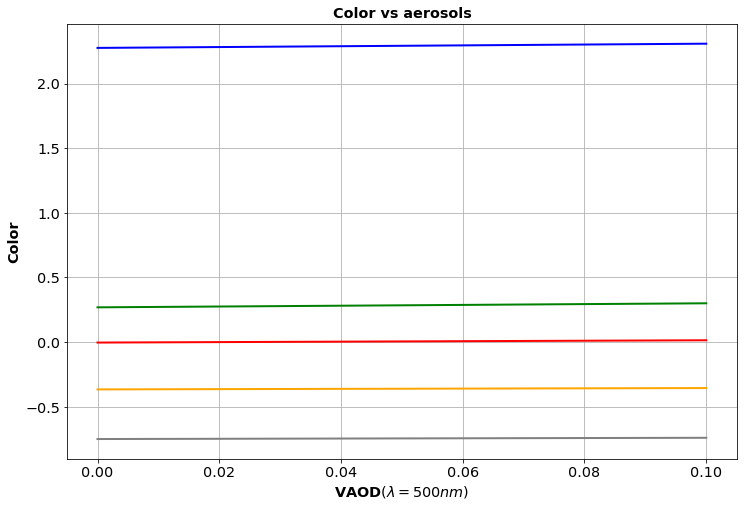

In [48]:
for ifilt in np.arange(photo.NBBANDS-1):
    mag1=rt_observations.get_magnitudeforfilternum(0,ifilt)
    mag2=rt_observations.get_magnitudeforfilternum(0,ifilt+1)
    plt.plot(tau_aerosol,mag1-mag2,color=photo.filtercolor[ifilt],lw=2)
plt.title("Color vs aerosols",weight='bold')
plt.xlabel("VAOD$(\lambda=500nm)$",weight='bold')
plt.ylabel("Color",weight='bold')
plt.grid()

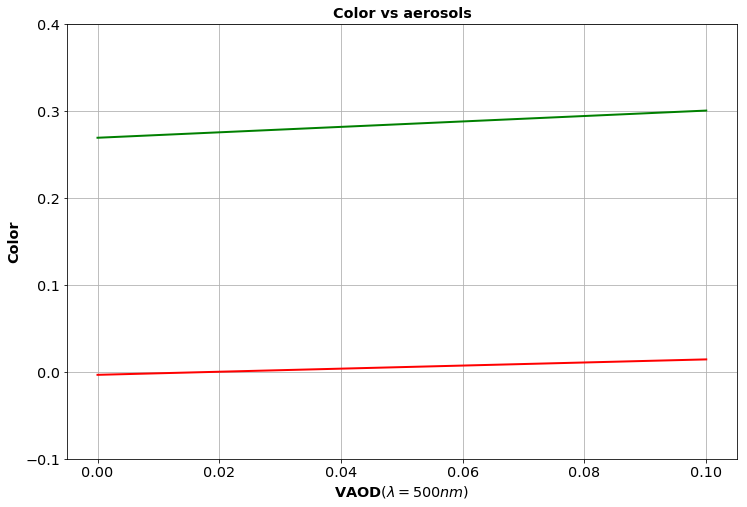

In [47]:
for ifilt in np.arange(photo.NBBANDS-1):
    mag1=rt_observations.get_magnitudeforfilternum(0,ifilt)
    mag2=rt_observations.get_magnitudeforfilternum(0,ifilt+1)
    plt.plot(tau_aerosol,mag1-mag2,color=photo.filtercolor[ifilt],lw=2)
plt.title("Color vs aerosols",weight='bold')
plt.xlabel("VAOD$(\lambda=500nm)$",weight='bold')
plt.ylabel("Color",weight='bold')
plt.ylim(-0.1,0.4)
plt.grid()